# Interactions - Lab

## Introduction

In this lab, you'll explore interactions in the Boston Housing dataset.

## Objectives

You will be able to:
- Implement interaction terms in Python using the `sklearn` and `statsmodels` packages 
- Interpret interaction variables in the context of a real-world problem 

## Build a baseline model 

You'll use a couple of built-in functions, which we imported for you below: 

In [123]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.datasets import load_boston
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

Import the Boston data set using `load_boston()`. We won't bother to preprocess the data in this lab. If you still want to build a model in the end, you can do that, but this lab will just focus on finding meaningful insights in interactions and how they can improve $R^2$ values.

In [124]:
regression = LinearRegression()
boston = load_boston()

Create a baseline model which includes all the variables in the Boston housing data set to predict the house prices. Then use 10-fold cross-validation and report the mean $R^2$ value as the baseline $R^2$.

In [125]:
## Save features dataframe as x
X = pd.DataFrame(boston['data'])
X.columns = boston['feature_names']
X.head()

## Save target dataframe as y
y = pd.DataFrame(boston['target'])
y.columns = ['target']
y.head()

df = pd.concat([X, y], axis=1)

## Create k-fold cross validation
cross_val = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y=y, scoring='r2', cv=cross_val))

In [126]:
baseline

0.7190106820189477

## See how interactions improve your baseline

Next, create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the $R^2$. We'll look at the 3 interactions which have the biggest effect on our $R^2$, so print out the top 3 combinations.

You will create a `for` loop to loop through all the combinations of 2 predictors. You can use `combinations` from itertools to create a list of all the pairwise combinations. To find more info on how this is done, have a look [here](https://docs.python.org/2/library/itertools.html).

In [127]:
from itertools import combinations
combinations = list(combinations(boston.feature_names, 2))
combinations[0]

('CRIM', 'ZN')

In [128]:
## code to find top 3 interactions by R^2 value here

int_terms = []
for comb in combinations:
    X['new_feat'] = X[comb[0]] * X[comb[1]]

    cross_val = KFold(n_splits=10, shuffle=True, random_state=1)
    baseline = np.mean(cross_val_score(regression, X, y=y, scoring='r2', cv=cross_val))
    int_terms.append((comb, baseline))
    top_three = sorted(int_terms, key = lambda x: x[1], reverse=True)[0:3]
print(top_three)

[(('RM', 'LSTAT'), 0.7864889421124028), (('RM', 'TAX'), 0.7750525123747647), (('RM', 'RAD'), 0.7682152400234057)]


## Look at the top 3 interactions: "RM" as a confounding factor

The top three interactions seem to involve "RM", the number of rooms as a confounding variable for all of them. Let's have a look at interaction plots for all three of them. This exercise will involve:

- Splitting the data up in 3 groups: one for houses with a few rooms, one for houses with a "medium" amount of rooms, one for a high amount of rooms 
- Create a function `build_interaction_rm()`. This function takes an argument `varname` (which can be set equal to the column name as a string) and a column `description` (which describes the variable or varname, to be included on the x-axis of the plot). The function outputs a plot that uses "RM" as a confounding factor. Each plot should have three regression lines, one for each level of "RM"  

The data has been split into high, medium, and low number of rooms for you.

In [129]:
rm = np.asarray(X[['RM']]).reshape(len(X[['RM']]))

In [130]:
high_rm = df[rm > np.percentile(rm, 67)]
med_rm = df[(rm > np.percentile(rm, 33)) & (rm <= np.percentile(rm, 67))]
low_rm = df[rm <= np.percentile(rm, 33)]

Create `build_interaction_rm()`.

In [141]:
def build_interaction_rm(varname, description):
    
    # Create regression objects
    regression_l = LinearRegression()
    regression_m = LinearRegression()
    regression_h = LinearRegression()
    
    # Fit regression lines to objects
    model_l = regression_l.fit(low_rm[varname].values.reshape(-1,1), low_rm['target'])
    model_m = regression_m.fit(med_rm[varname].values.reshape(-1,1), med_rm['target'])
    model_h = regression_h.fit(high_rm[varname].values.reshape(-1,1), high_rm['target'])
    
    # Use model to predict values
    pred_l = model_l.predict(low_rm[varname].values.reshape(-1,1))
    pred_m = model_m.predict(med_rm[varname].values.reshape(-1,1))
    pred_h = model_h.predict(high_rm[varname].values.reshape(-1,1))
    
    coef_l = model_l.coef_
    coef_m = model_m.coef_
    coef_h = model_h.coef_
    
    # Plot results
    fig, ax = plt.subplots(figsize=(12,8))
    
    plt.scatter(low_rm[varname], low_rm['target'], label='High # Rooms')
    plt.scatter(med_rm[varname], med_rm['target'], label='Med # Rooms')
    plt.scatter(high_rm[varname], high_rm['target'], label='Low # Rooms')
    
    plt.plot(low_rm[varname], pred_l, linewidth=2, label=f'Slope = {round(coef_l[0], 2)}')
    plt.plot(med_rm[varname], pred_m, linewidth=2, label=f'Slope = {round(coef_m[0], 2)}')
    plt.plot(high_rm[varname], pred_h, linewidth=2, label=f'Slope = {round(coef_h[0], 2)}')
    
    ax.set_xlabel(description)
    ax.set_ylabel('target')
    ax.legend()
    plt.show();

Next, use `build_interaction_rm()` with the three variables that came out with the highest effect on $R^2$. 

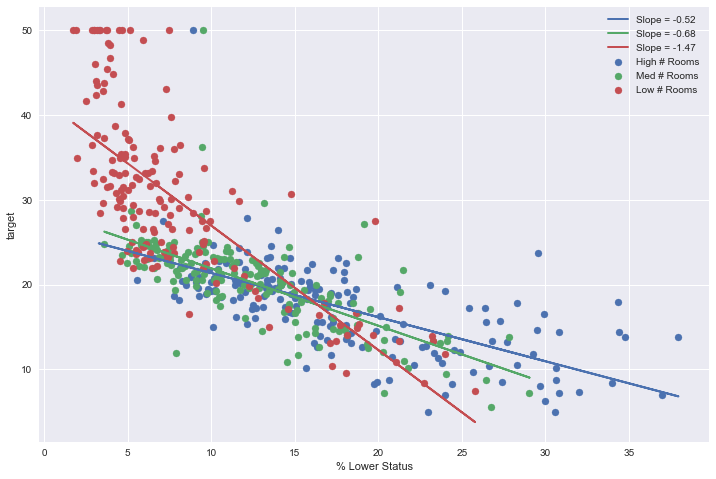

In [144]:
build_interaction_rm(varname='LSTAT', description='% Lower Status')

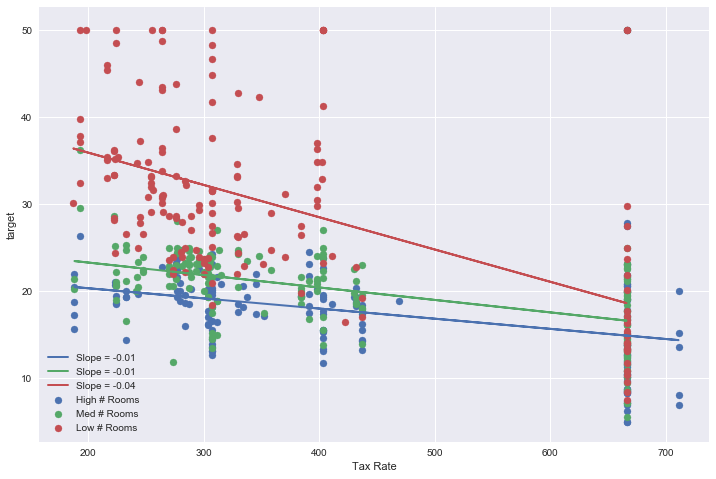

In [145]:
build_interaction_rm(varname='TAX', description='Tax Rate')

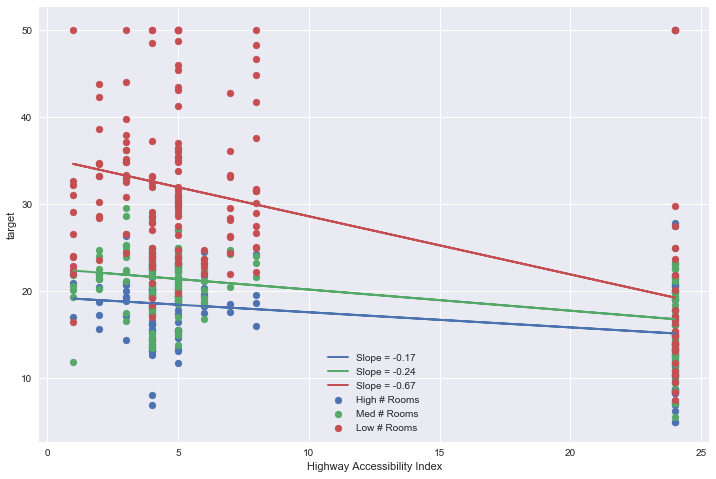

In [146]:
build_interaction_rm(varname='RAD', description='Highway Accessibility Index')

## Build a final model including all three interactions at once

Use 10-fold cross-validation to build a model using all the above interactions. 

In [149]:
# Instantiate a kfold object and a regression object
cross_val = KFold(n_splits=10, shuffle=True, random_state=1)
regression = LinearRegression()

In [150]:
# Add appropriate interaction data to df
df_inters = X.copy()
df_inters['RM_LSTAT'] = X.RM * X.LSTAT
df_inters['RM_TAX'] = X.RM * X.TAX
df_inters['RM_RAD'] = X.RM * X.RAD

In [151]:
# Model
final_model = np.mean(cross_val_score(regression, df_inters, y, scoring='r2', cv=cross_val))
final_model

0.7851761763556198

Our $R^2$ has increased considerably! Let's have a look in `statsmodels` to see if all these interactions are significant.

In [153]:
df_inters_sm = sm.add_constant(df_inters)
final_olsmodel = sm.OLS(y, df_inters_sm)
result = final_olsmodel.fit()
result.summary()

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     126.6
Date:                Tue, 17 Dec 2019   Prob (F-statistic):          1.87e-166
Time:                        21:20:13   Log-Likelihood:                -1413.2
No. Observations:                 506   AIC:                             2862.
Df Residuals:                     488   BIC:                             2938.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.8732      7.615     -2.216      0.027     -31.835      -1.912
CRIM          -0.1618      0.028     -5.720      0.000      -0.217      -0.106
ZN             0.0174      0.012      1.461      0.145      -0.006       0.041
INDUS          0.0944      0.053      1.787      0.075      -0.009       0.198
CHAS           2.6096      0.740      3.527      0.000       1.156       4.064
NOX          -13.4446      3.275     -4.105      0.000     -19.880      -7.009
RM            10.6918      0.992     10.778      0.000       8.743      12.641
AGE            0.0072      0.011      0.628      0.530      -0.015       0.030
DIS           -0.9510      0.175     -5.449      0.000      -1.294      -0.608
RAD            0.6610      0.478      1.383      0.167      -0.278       1.600
TAX            0.0344      0.025      1.400      0.162      -0.014       0.083
PTRATIO       -0.6957      0.113     -6.147      0.000      -0.918      -0.473
B              0.0128      0.007      1.814      0.070      -0.001       0.027
LSTAT          1.2738      0.253      5.041      0.000       0.777       1.770
new_feat      -0.0004      0.000     -1.201      0.230      -0.001       0.000
RM_LSTAT      -0.2896      0.041     -7.116      0.000      -0.370      -0.210
RM_TAX        -0.0074      0.004     -1.870      0.062      -0.015       0.000
RM_RAD        -0.0621      0.078     -0.793      0.428      -0.216       0.092
==============================================================================
Omnibus:                      252.409   Durbin-Watson:                   1.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2471.073
Skew:                           1.944   Prob(JB):                         0.00
Kurtosis:                      13.104   Cond. No.                     2.40e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

What is your conclusion here?

In [ ]:
# Only one of the three interactions (RM_LSTAT) seems to have had a significant effect on the model.

## Summary

You should now understand how to include interaction effects in your model! As you can see, interactions can have a strong impact on linear regression models, and they should always be considered when you are constructing your models.